## Notebook to calculate Sobol indices for performing model parameter sensitivity analysis

### Model: LGBM
### Property: Ionic conductivity

**Created on 15th December, 2023; modified on 14th February, 2024**

In [1]:
%%bash
pwd
ls -ltr

/Users/riteshk/Library/CloudStorage/Box-Box/Research-postdoc/liquid-electrolyte-ML/Science-rev-1/sensitivity-analysis/ionic-conductivity
total 1016
-rw-------@ 1 riteshk  staff   586008 Dec  8 11:48 train_multi_comp_add.csv
-rw-------@ 1 riteshk  staff   554867 Dec  8 11:48 train_multi_comp_comb.csv
-rw-------@ 1 riteshk  staff    72447 Dec  8 11:48 val_multi_comp_add.csv
-rw-------@ 1 riteshk  staff    69407 Dec  8 11:48 val_multi_comp_comb.csv
-rw-------@ 1 riteshk  staff    73239 Dec  8 11:49 test_multi_comp_add.csv
-rw-------@ 1 riteshk  staff    69314 Dec  8 11:49 test_multi_comp_comb.csv
-rw-------@ 1 riteshk  staff   728011 Dec  8 11:49 all_multi_comp.csv
-rw-------@ 1 riteshk  staff   626696 Dec  8 11:49 all_multi_comp_add.csv
-rw-------@ 1 riteshk  staff   703675 Dec  8 11:49 all_multi_comp_comb.csv
-rw-r--r--@ 1 riteshk  staff  1822439 Dec 13 18:17 sensitivity_data_train_1.csv
-rw-------@ 1 riteshk  staff    99450 Dec 13 18:50 preds_test.csv
-rw-------@ 1 riteshk  staff   796

In [4]:
import numpy as np
# from keras.models import load_model
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Arial'
from SALib.sample import saltelli
from SALib.analyze import sobol
import pandas as pd
import os, sys
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors, rdMolDescriptors, Draw, PandasTools
import pickle
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import dask
import dask.array
from dask import delayed
from dask.distributed import Client
import lightgbm
lightgbm.__version__

'4.1.0'

In [4]:
# path = '/Users/riteshk/Library/CloudStorage/Box-Box/Research-postdoc/liquid-electrolyte-ML/Science-rev-1/coulombic-efficiency_1.1/using-pretrainedGR/gr-embed-200/common-log-output/stratified-split-2-cv/' ## on MacBook Pro

In [4]:
val_df = pd.read_csv('train_qsar_rand_cond.csv')
# train_df = pd.read_csv(path + 'strat_rs30_train_gr_comb_add.csv')
train_df = pd.read_csv('val_qsar_rand_cond.csv')
test_df = pd.read_csv('test_qsar_rand_cond.csv')
train_df

,solv_comb_sm,salt_smiles,fr_func_grp_1_solv,fr_func_grp_2_solv,fr_func_grp_3_solv,fr_func_grp_4_solv,fr_func_grp_5_solv,fr_func_grp_6_solv,fr_func_grp_7_solv,fr_func_grp_8_solv,...,fr_func_grp_40_salt,fr_func_grp_41_salt,fr_func_grp_42_salt,fr_func_grp_43_salt,num_heavy_atom_salt,num_rot_bond_salt,mw_salt,conc_salt,temperature,conductivity_log
0,O=C1OCCO1.CCOC(=O)OC.CC(=O)OC,[Li+].F[P-](F)(F)(F)(F)F,0,0,0,0,0,0,0,0,...,0,0,0,0,8,0,144.964181,1.500000,30.00000,1.103804
1,CS(=O)(=O)F,[Li+].C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F,0,0,0,0,0,0,0,0,...,0,0,0,0,16,2,279.917842,1.000000,1.73000,0.250420
2,C1COB(OCCOB2OCCCO2)OC1.C1COC(=O)O1,[Li+].[O-]Cl(=O)(=O)=O,0,0,0,2,0,0,0,0,...,0,0,0,0,6,0,98.949060,2.500000,80.68127,0.986401
3,O=C1CCCO1,[B-](C1=CC=CC=C1)(C2=CC=CC=C2)(C3=CC=CC=C3)C4=...,0,0,0,0,0,0,0,0,...,0,0,1,1,42,4,319.166355,0.010483,25.00000,-0.662442
4,CC1COC(=O)O1.CCOC(=O)OCC,[Li+].F[P-](F)(F)(F)(F)F,0,0,0,0,0,0,0,0,...,0,0,0,0,8,0,144.964181,2.316200,29.40000,0.578525
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1005,C1COC(=O)O1.CCOC(=O)OC.COC(=O)OC,[Li+].[B-]12(OC(=O)C(=O)O1)OC(=O)C(=O)O2,0,0,0,0,0,0,0,0,...,0,0,0,0,14,0,186.969171,0.600000,-10.00000,0.296835
1006,CC1COC(=O)O1,[Li+].[B-]12(OC(=O)C(=O)O1)OC(=O)C(=O)O2,0,0,0,0,0,0,0,0,...,0,0,0,0,14,0,186.969171,0.410000,19.50000,0.472171
1007,CC1COC(=O)O1.O=C1OCCO1,[Li+].F[P-](F)(F)(F)(F)F,0,0,0,0,0,0,0,0,...,0,0,0,0,8,0,144.964181,1.500000,60.00000,1.037546
1008,CC1COC(=O)O1.CCOC(=O)OCC,[B-](F)(F)(F)F.CC[N+](CC)(CC)CC,0,0,0,0,0,0,0,0,...,0,0,0,1,14,0,87.003467,0.251163,60.00000,0.690902


In [5]:
df_all = pd.concat([train_df, val_df, test_df], axis=0, ignore_index=True)
df_all.reset_index(drop=True, inplace=True)

In [ ]:
# train_df.drop(columns=['fr_func_grp_11_salt'], inplace=True)
# val_df.drop(columns=['fr_func_grp_11_salt'], inplace=True)
# test_df.drop(columns=['fr_func_grp_11_salt'], inplace=True)

In [6]:
# df_all = pd.concat([train_df, val_df, test_df])
df_all.drop(columns=['fr_func_grp_20_salt'], inplace=True)
train_df.drop(columns=['fr_func_grp_20_salt'], inplace=True)
val_df.drop(columns=['fr_func_grp_20_salt'], inplace=True)
test_df.drop(columns=['fr_func_grp_20_salt'], inplace=True)

In [7]:
X_train = train_df.iloc[:,2:-1]
y_train = train_df.iloc[:,-1]

X_test = test_df.iloc[:,2:-1]
y_test = test_df.iloc[:,-1]

X_val = val_df.iloc[:,2:-1]
y_val = val_df.iloc[:,-1]

X_all = df_all.iloc[:,2:-1]
y_all = df_all.iloc[:,-1]

## scaling the data
std_scale = StandardScaler().fit(X_train)
X_train_std = std_scale.transform(X_train)
X_train_std = pd.DataFrame(X_train_std, columns=X_train.columns)
X_test_std  = std_scale.transform(X_test)
X_test_std = pd.DataFrame(X_test_std, columns=X_train.columns)
X_val_std  = std_scale.transform(X_val)
X_val_std = pd.DataFrame(X_val_std, columns=X_train.columns)
X_all_std = std_scale.transform(X_all)
X_all_std = pd.DataFrame(X_all_std, columns=X_train.columns)

In [8]:
X_train_ = np.array(X_train_std)
X_val_ = np.array(X_val_std)
X_test_ = np.array(X_test_std)
X_all_ = np.array(X_all_std)

In [9]:
lgbm_models = []
for i in range(1,6):
#     filename = path + f'lgbm_cond_rand_fold_{i}.sav'
    filename = f'lgbm_cond_rand_fold_{i}.sav'
    loaded_model = pickle.load(open(filename, 'rb'))
    lgbm_models.append(loaded_model)

In [10]:
## generate a list of max and min of each feature in the form [[min1, max1], [min2, max2], ...]
min_max = []
for i in range(X_all_.shape[1]):
    min_max.append([X_all_[:,i].min(), X_all_[:,i].max()])
min_max

[[0.0, 1.0],
 [-0.06305666611194317, 15.858751527153707],
 [-0.054581553460422226, 18.321208111548394],
 [-0.09482093118615209, 10.54619467970425],
 [-0.10485160165321433, 11.661828139429728],
 [0.0, 1.0],
 [-0.03148142750102793, 31.76476034853718],
 [0.0, 1.0],
 [0.0, 1.0],
 [-0.384411306624789, 7.423284518971931],
 [-0.21420035169049115, 8.800064448617679],
 [0.0, 1.0],
 [-0.08569874086727462, 19.148907542676586],
 [0.0, 1.0],
 [-0.04454354031873738, 22.44994432064364],
 [-0.07053456158585984, 14.177446878757827],
 [0.0, 1.0],
 [-0.03148142750102793, 31.76476034853718],
 [-1.5090223234095719, 1.9786494080404682],
 [-0.04454354031873739, 22.449944320643645],
 [0.0, 1.0],
 [-0.04454354031873739, 22.449944320643645],
 [0.0, 1.0],
 [-0.05458155346042223, 18.321208111548394],
 [0.0, 1.0],
 [0.0, 1.0],
 [-0.07053456158585984, 14.177446878757827],
 [-0.03148142750102793, 31.76476034853718],
 [-0.03148142750102792, 31.764760348537173],
 [-0.04454354031873739, 22.449944320643645],
 [-0.156110

In [11]:
# Define the problem for sensitivity analysis
problem = {
    'num_vars': lgbm_models[0].n_features_in_,  # Number of features in the model
    'names': X_train.columns.to_list(),  # Feature names
    'bounds': min_max  # feature range
}

**Average of all five models**

In [12]:
first_order_sobol = []
total_order_sobol = []

# Create a Dask client with 4 workers
client = Client(n_workers=16)

# Generate samples
param_values = saltelli.sample(problem, 2**10)
print('sample generation done...')

count = 0
for model in lgbm_models:
    # Evaluate the model for each sample
    predictions = []
    for params in param_values:
        prediction = model.predict(np.array([params]))
        if np.isscalar(prediction):
            predictions.append(prediction)
        else:
            predictions.append(prediction[0])

    predictions = np.array(predictions)

    # Perform Sobol analysis
    sobol_analysis = sobol.analyze(problem, predictions.ravel())
    print('Sobol analsis done for model: ', count)
    count += 1

    # Store the first-order and total-order Sobol indices
    first_order_sobol.append(sobol_analysis['S1'])
    total_order_sobol.append(sobol_analysis['ST'])

# Convert the lists to NumPy arrays
first_order_sobol = np.array(first_order_sobol)
total_order_sobol = np.array(total_order_sobol)

# Compute the average and standard deviation
avg_first_order_sobol = np.mean(first_order_sobol, axis=0)
std_first_order_sobol = np.std(first_order_sobol, axis=0)
avg_total_order_sobol = np.mean(total_order_sobol, axis=0)
std_total_order_sobol = np.std(total_order_sobol, axis=0)

# Create a DataFrame with the results
df_sobol = pd.DataFrame({
    'feature': problem['names'],
    'avg_first_order': avg_first_order_sobol,
    'std_first_order': std_first_order_sobol,
    'avg_total_order': avg_total_order_sobol,
    'std_total_order': std_total_order_sobol,
})

# Set the feature names as the index
df_sobol.set_index('feature', inplace=True)

df_sobol

/scratch/midway3/riteshk/anaconda3/lib/python3.9/site-packages/distributed/node.py:180: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 36169 instead
  warnings.warn(
/scratch/local/jobs/16072864/ipykernel_4020946/1033189214.py:8: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  param_values = saltelli.sample(problem, 2**10)


sample generation done...
Sobol analsis done for model:  0
Sobol analsis done for model:  1
Sobol analsis done for model:  2
Sobol analsis done for model:  3
Sobol analsis done for model:  4


,avg_first_order,std_first_order,avg_total_order,std_total_order
feature,,,,
fr_func_grp_1_solv,0.000000,0.000000,0.000000,0.000000
fr_func_grp_2_solv,0.000000,0.000000,0.000000,0.000000
fr_func_grp_3_solv,0.000000,0.000000,0.000000,0.000000
fr_func_grp_4_solv,0.026844,0.024927,0.020755,0.011979
fr_func_grp_5_solv,-0.000110,0.000511,0.000280,0.000328
...,...,...,...,...
num_heavy_atom_salt,0.020320,0.020355,0.032671,0.012921
num_rot_bond_salt,0.001049,0.000891,0.002825,0.001811
mw_salt,0.024652,0.016580,0.042443,0.026884


In [16]:
client.close()

In [13]:
param_values

array([[ 1.46484375e-03,  5.93094437e+00,  8.17325005e+00, ...,
         9.81982217e-01,  6.35083952e+00, -3.22120731e+00],
       [ 7.57324219e-01,  5.93094437e+00,  8.17325005e+00, ...,
         9.81982217e-01,  6.35083952e+00, -3.22120731e+00],
       [ 1.46484375e-03,  1.44826968e+01,  8.17325005e+00, ...,
         9.81982217e-01,  6.35083952e+00, -3.22120731e+00],
       ...,
       [ 7.19238281e-01,  7.65684350e+00,  1.00036510e+01, ...,
         1.18340226e+00,  5.08969740e+00, -1.34277012e+00],
       [ 7.19238281e-01,  7.65684350e+00,  1.00036510e+01, ...,
         1.18340226e+00,  4.85940188e+00,  1.56887564e-01],
       [ 7.19238281e-01,  7.65684350e+00,  1.00036510e+01, ...,
         1.18340226e+00,  4.85940188e+00, -1.34277012e+00]])

In [14]:
df_sobol.to_csv('sobol_analysis_lgbm_cond_rand.csv')

In [6]:
## plotting on local computer (MacBook Pro)
orange = (0.984, 0.713, 0.305) # 251, 182, 78 
anvil = (0.298, 0.78, 0.77) # 76, 199, 196

In [8]:
df_sobol = pd.read_csv('sobol_analysis_lgbm_cond_rand.csv')
df_sobol

,feature,avg_first_order,std_first_order,avg_total_order,std_total_order
0,fr_func_grp_1_solv,0.000000,0.000000,0.000000,0.000000
1,fr_func_grp_2_solv,0.000000,0.000000,0.000000,0.000000
2,fr_func_grp_3_solv,0.000000,0.000000,0.000000,0.000000
3,fr_func_grp_4_solv,0.026844,0.024927,0.020755,0.011979
4,fr_func_grp_5_solv,-0.000110,0.000511,0.000280,0.000328
...,...,...,...,...,...
97,num_heavy_atom_salt,0.020320,0.020355,0.032671,0.012921
98,num_rot_bond_salt,0.001049,0.000891,0.002825,0.001811
99,mw_salt,0.024652,0.016580,0.042443,0.026884
100,conc_salt,0.041365,0.025798,0.098532,0.029482


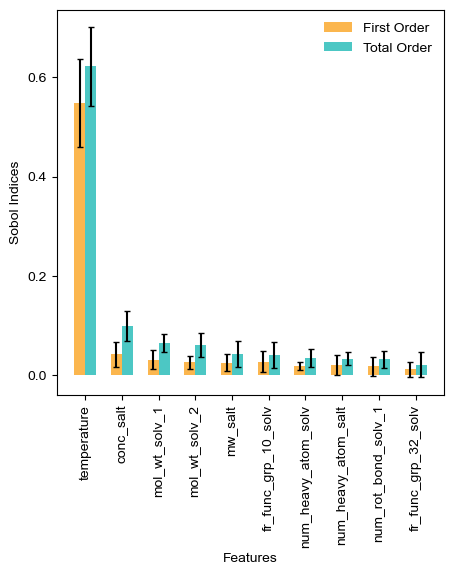

In [24]:
# Plotting Sobol indices for top 10 features having highest total order indices
df_sobol_ = df_sobol.sort_values(by='avg_total_order', ascending=False).iloc[:10,:]
features = df_sobol_['feature']
avg_first_order = df_sobol_['avg_first_order']
std_first_order = df_sobol_['std_first_order']
avg_total_order = df_sobol_['avg_total_order']
std_total_order = df_sobol_['std_total_order']

# Create a figure and a set of subplots
fig, ax = plt.subplots(figsize=(5, 5))

# Set the bar width
bar_width = 0.3

# Set the opacity
opacity = 1.0

# Plot the first order Sobol indices
rects1 = ax.bar(np.arange(len(features)) - bar_width/2, avg_first_order, bar_width, alpha=opacity, color=orange, yerr=std_first_order, label='First Order', capsize=2)

# Plot the total order Sobol indices
rects2 = ax.bar(np.arange(len(features)) + bar_width/2, avg_total_order, bar_width, alpha=opacity, color=anvil, yerr=std_total_order, label='Total Order', capsize=2)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Features')
ax.set_ylabel('Sobol Indices')
# ax.set_title('Sobol Indices by Feature')
ax.set_yticks([0.0, 0.2, 0.4, 0.6])
ax.set_yticklabels([0.0, 0.2, 0.4, 0.6])
ax.set_xticks(np.arange(len(features)))
ax.set_xticklabels(features, rotation=90)
ax.legend(frameon=False)

# Show the plot
# plt.show()
plt.savefig('plot_sobol_analysis_lgbm_cond_rand.eps', dpi=300)

<AxesSubplot:xlabel='feature'>

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


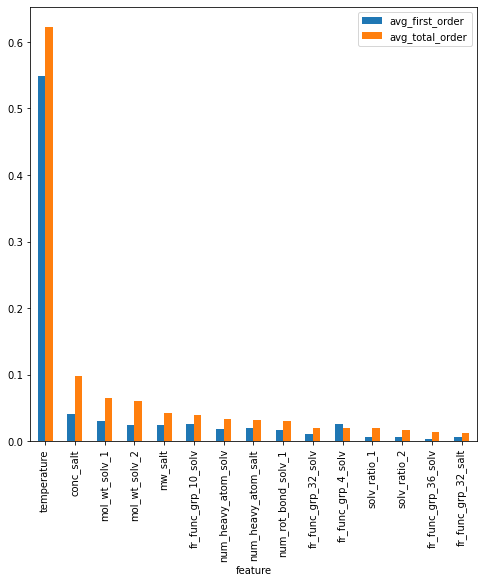

In [15]:
# df_ = df_sobol.sort_values(by='avg_total_order', ascending=False).iloc[:15,:]
# df_[['avg_first_order', 'avg_total_order']].plot.bar(yerr=df_[['std_first_order', 'std_total_order']], rot=90, figsize=(8,8))